# YOLOv4 Object Detection on Webcam In Google Colab
This notebook will walkthrough all the steps for performing YOLOv4 object detections on your webcam while in Google Colab. We will be using scaled-YOLOv4 (yolov4-csp) for this tutorial, the fastest and most accurate object detector there currently is.

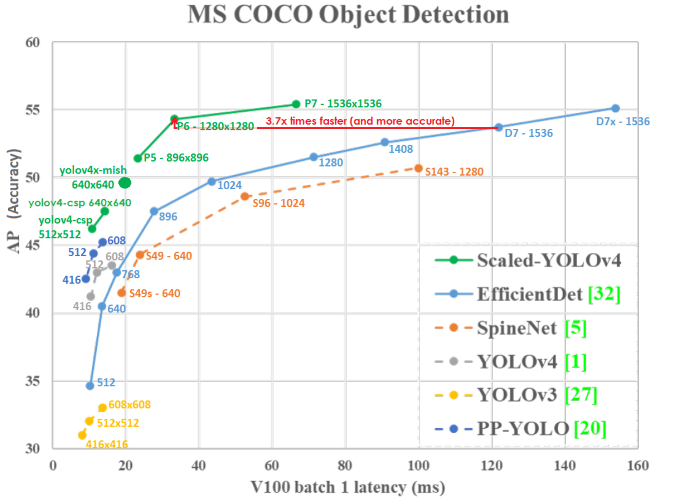

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

# FEATURES

In [ ]:
pip install twilio

In [ ]:
pip install num2words

In [ ]:
import os
from os.path import exists, join, expanduser
 
project_name = "pytorch-dc-tts"
if not exists(project_name):
  ! git clone --quiet https://github.com/tugstugi/{project_name}
  ! cd {project_name} && pip install -q -r requirements.txt

In [ ]:
# download text2mel
if not exists("ljspeech-text2mel.pth"):
  ! wget -q -O ljspeech-text2mel.pth https://www.dropbox.com/s/4t13ugxzzgnocbj/step-300K.pth
 
# download SSRN
if not exists("ljspeech-ssrn.pth"):
  ! wget -q -O ljspeech-ssrn.pth https://www.dropbox.com/s/gw4aqrgcvccmg0g/step-100K.pth

In [ ]:
import sys
sys.path.append(project_name)
 
import warnings
warnings.filterwarnings("ignore")  # ignore warnings in this notebook
 
import numpy as np
import torch
 
from tqdm import *
import IPython
from IPython.display import Audio
 
from hparams import HParams as hp
from audio import save_to_wav
from models import Text2Mel, SSRN
from datasets.lj_speech import vocab, idx2char, get_test_data

In [ ]:
class TTS:
  
  def tts(self,sentence):
 
    torch.set_grad_enabled(False)
    text2mel = Text2Mel(vocab)
    text2mel.load_state_dict(torch.load("ljspeech-text2mel.pth").state_dict())
    text2mel = text2mel.eval()
    ssrn = SSRN()
    ssrn.load_state_dict(torch.load("ljspeech-ssrn.pth").state_dict())
    ssrn = ssrn.eval()
 
    normalized_sentence = "".join([c if c.lower() in vocab else str(c) if c.isdigit() else '' for c in sentence])
    print(normalized_sentence)
    
    sentences = [normalized_sentence]
    max_N = len(normalized_sentence)
    L = torch.from_numpy(get_test_data(sentences, max_N))
    zeros = torch.from_numpy(np.zeros((1, hp.n_mels, 1), np.float32))
    Y = zeros
    A = None
 
    for t in range(hp.max_T):
      _, Y_t, A = text2mel(L, Y, monotonic_attention=True)
      Y = torch.cat((zeros, Y_t), -1)
      _, attention = torch.max(A[0, :, -1], 0)
      attention = attention.item()
      if L[0, attention] == vocab.index('E'):  # EOS
          break
 
    _, Z = ssrn(Y)
    
    Z = Z.cpu().detach().numpy()
    save_to_wav(Z[0, :, :].T, '%d.wav' % (1))
    IPython.display.display(Audio('%d.wav' % (1), rate=hp.sr, autoplay=True))

In [ ]:
import requests
from geopy import Nominatim
 
class Loc:
  def loca(self):
    req = requests.get('https://get.geojs.io/')
 
    ip_request = requests.get('https://get.geojs.io/v1/ip.json')
 
    ipAdd = ip_request.json()['ip']
 
    #print(ipAdd)
 
    url='https://get.geojs.io/v1/ip/geo/'+ipAdd+'.json'
 
    geo_req=requests.get(url)
 
    geo_data = geo_req.json()
 
    lat=geo_data['latitude']
    lat=19.227225
 
    lon=geo_data['longitude']
    lon=72.846055
 
    #print(geo_data)
    #print(lat)
    #print(lon)
 
    geolocator=Nominatim(user_agent='test/1')
    location= geolocator.reverse(str(lat)+','+str(lon))
    #location= geolocator.reverse(str(19.227225)+','+str(72.846055))
    print("The user's location is "+str(location))
    locs="The user's location is "+str(location)
    #return "The user's location is "+str(location)
    
    return lat,lon,locs

In [ ]:
import requests
import os
from datetime import datetime
from num2words import num2words
 
class Weather:
  def give_wu(self):
    user_api='32efefaf435edc96b5c402ce8dd53711'
    #location="Mumbai"
 
    l=Loc()
    locy=l.loca()
    lat=str(locy[0])
    lon=str(locy[1])
    print(lat,lon)
    api_link="https://api.openweathermap.org/data/2.5/weather?lat="+lat+"&lon="+lon+"&appid="+user_api
 
    #api_link="https://api.openweathermap.org/data/2.5/weather?q="+location+"&appid="+user_api
 
    api_link=requests.get(api_link)
    api_data= api_link.json()
    #print(type(api_data))
    #print(api_data)
 
    temp=int((api_data['main']['temp'])-273.15)
    weather_desc=api_data['weather'][0]['description']
    humid=api_data['main']['humidity']
    wind_speed=api_data['wind']['speed']
    wind_speed=wind_speed*3.6
    date_time=datetime.now().strftime("%d %b %Y | %I:%M:%S %p")
 
    #print(api_data)
    #print(lat, lon)
 
    #temp1=str(round(temp))
    #humid1=str(humid)
    #wind_speed1=str(round(wind_speed,2))
    #print(type(temp1))
 
    temp1=num2words(temp)
    humid1=num2words(humid)
    wind_speed1=num2words(round(wind_speed,2))
    #print(type(temp1))
 
    w1="The weather at this location is "+weather_desc
    w2="The temperature is "+temp1+" degree celsius"
    w3="The humidity is "+humid1+" percentage"
    w4="The wind speed is "+wind_speed1+" kilometer per hour"
 
    print(w1)
    print(w2)
    print(w3)
    print(w4)
 
    t=TTS() 
    t.tts(w1)
    t.tts(w2)
    t.tts(w3)
    t.tts(w4)

In [ ]:
import smtplib
#import voicent
from twilio.rest import Client
 
class Alert:
  def sendalert(self):
    sender='be35.project@gmail.com'
    receiver='be35.project@gmail.com'
    password='BE1234567'
 
 
    smtp_server=smtplib.SMTP_SSL('smtp.gmail.com',465)
    smtp_server.login(sender,password)
 
    l=Loc()
    locy=l.loca()
 
    subject="Emergency Alert"
    body="Emergency alert:\n "+"The user's location is "+locy[2]
    msg=f'Subject: {subject}\n\n{body}'
    #smtp_server.sendmail(sender,receiver,msg)
 
    #v=Voicent()ko 
    #v.callText("8879214174", "Hello, how are you doing", "1")
 
    account_sid = 'AC91480ca18dc61c7615ddef0b34b67597'
    auth_token = 'be58a2d8ffe40f836d76a82c2e09736d'
    client = Client(account_sid, auth_token)
 
    """
    call = client.calls.create(
                            twiml='<Response><Say>Ahoy, World!</Say></Response>',
                            to='+918879214174',
                            from_='+17343445867'
                      )
 
    print(call.sid)
    """
 
    """
    message = client.messages \
                    .create(
                        body="Emergency alert.\n "+"The user's location is "+locy[2],
                        to='+918879214174',
                        from_='+17343445867'
                    )
 
    print(message.sid)
    """
    print("Alert sent")

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-05-26 11:19:17--  https://docs.google.com/uc?export=download&confirm=ov9f&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 108.177.97.138, 108.177.97.139, 108.177.97.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-98-docs.googleusercontent.com/docs/securesc/cn90kbajvhif23av7dlkhkshjmdr5ggp/tc6e5dc85kdm5tfj3333e5gngd8btj38/1622027925000/17800843676226924807/05510210428842869076Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-05-26 11:19:17--  https://doc-08-98-docs.googleusercontent.com/docs/securesc/cn90kbajvhif23av7dlkhkshjmdr5ggp/tc6e5dc85kdm5tfj3333e5gngd8btj38/1622027925000/17800843676226924807/05510210428842869076Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-08-98-docs.googleusercontent.com (doc-08-98-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connectin

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

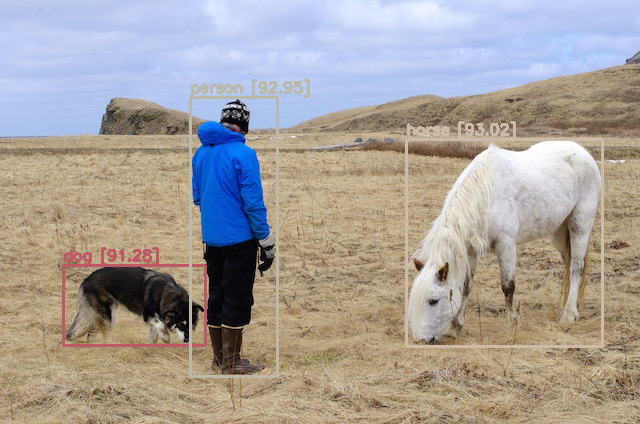

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
def capture_image():
  try:
    filename = take_photo('photo.jpg')
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

## YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream. 

YOLOv4 is so fast that it can run the detections in real-time!

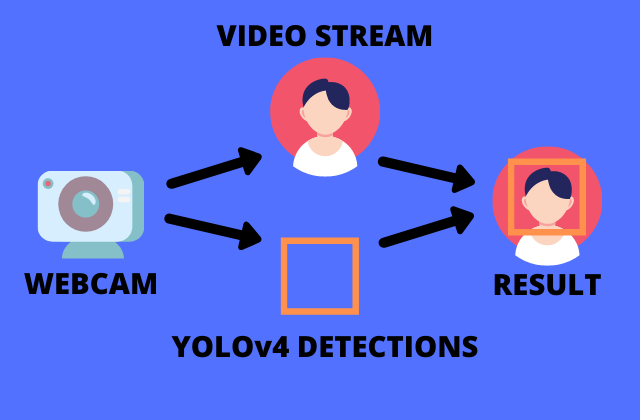

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
def capture_video(t):
  # start streaming video from webcam
  video_stream()
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      frame = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      # call our darknet helper on video frame
      detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

      # loop through detections and draw them on transparent overlay image
      for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          class_colors[label], 2)
        
        t.tts(label+' detected')
        print(label+' detected')
        time.sleep(5)

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

In [ ]:
import IPython
import time
from google.colab import output

RECORD = """
console.log('HERe')
console.log('Here');
console.log(window);
var synth = window.speechSynthesis;
console.log(synth)
window.SpeechRecognition = window.webkitSpeechRecognition || window.SpeechRecognition;
var recognition = new window.SpeechRecognition();
console.log(recognition)
speechToText = ""
started = false
stopped = false
recognition.onresult = function(event) {
  console.log('Event aya kya??');
  console.log(event);
  speechToText = event.results[0][0].transcript;
  window.som = speechToText
  console.log(window)
  
};
recognition.onspeechend = () => {
  recognition.stop();
  console.log('Stopped');
};

recognition.onstart = () => {
  console.log('Started');
  
};
 var display=(speechToText)=>{
   return speechToText;
};

console.log(recognition.start)
window.som = "Our current setter value"
recognition.start();
"""

 
def speak():
  display(IPython.display.Javascript(data=RECORD))
  time.sleep(10)
  data = output.eval_js('som')

  print(data)
  return data

In [ ]:
speak()

<IPython.core.display.Javascript object>

Our current setter value


'Our current setter value'

In [ ]:
t=TTS()
data=''
while 'exit' not in data:
  t.tts('Start Speaking')
  time.sleep(2)
  data=speak()
  t.tts('Speech Recorded')
  if 'capture video' in data:
    t.tts('Video Started Capturing')
    capture_video(t)
    t.tts('Process Completed')
  elif "tell me current location" in data:
    t.tts('Fetching current Location')
    l=Loc()
    ls=l.loca()
    t.tts(ls[2])
    print(ls[2])
    print("Loc")
    time.sleep(5)
    t.tts('Process Completed')
  elif "give me weather update" in data:
    t.tts('Fetching Weather Updates')
    w=Weather()
    w.give_wu()
    print("WU")
    t.tts('Process Completed')
  elif "send alert" in data:
    t.tts('Sending Alert')
    a=Alert()
    a.sendalert()
    t.tts("Alert sent")
    print("Alert")
    t.tts('Process Completed')
  elif "disable sound" in data:
    t.tts('Sound Disabled')
    time.sleep(5)
    t.tts('To Enable Sound, speak enable sound')
    time.sleep(4)
    while 'enable sound' not in data:
      data=speak()
      time.sleep(5)
    t.tts('Sound Enabled')
    continue
  elif 'exit' in data:
    t.tts('Exiting')
    continue
  else:
    t.tts('No Matches Found, You need to start speaking Again')
    time.sleep(5)
 
t.tts('Thank You For Your Time')

Start Speaking


<IPython.core.display.Javascript object>

capture video
Speech Recorded


Video Started Capturing


<IPython.core.display.Javascript object>

person detected


person detected
person detected


person detected
person detected


person detected
Process Completed


Start Speaking


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored